# Demo
### Foreign key: connect two table nodes

In [88]:
import sqlparse
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [89]:
# Function to parse SQL and extract table, fields, primary keys, and foreign keys
def parse_sql(sql):
    tables = {}
    foreign_keys = []

    # Split and process each CREATE TABLE statement
    statements = sqlparse.split(sql)
    for statement in statements:
        parsed = sqlparse.parse(statement)[0]
        tokens = [token for token in parsed.tokens if not token.is_whitespace]

        if 'CREATE TABLE' in statement.upper():
            table_name = None
            table_fields = []
            primary_key = None

            # Process each line in the create statement
            lines = statement.splitlines()
            for line in lines:
                line = line.strip()

                # Extract table name
                if line.upper().startswith('CREATE TABLE'):
                    table_name = line.split('"')[1]

                # Extract primary key
                elif 'PRIMARY KEY' in line.upper():
                    primary_key = line.split('"')[1]

                # Extract foreign keys
                elif 'FOREIGN KEY' in line.upper():
                    local_field = line.split('(')[1].split(')')[0].strip('"')
                    ref_table = line.split('REFERENCES')[1].split('(')[0].strip().strip('"')
                    ref_field = line.split('REFERENCES')[1].split('(')[1].split(')')[0].strip('"')
                    foreign_keys.append((table_name, local_field, ref_table, ref_field))

                # Extract other fields
                elif line and ('FOREIGN KEY' not in line) and ('PRIMARY KEY' not in line) and (not line.endswith(');')):
                    field_name = line.split()[0].strip('"')
                    table_fields.append(field_name)

            # Add the table and its fields to the tables dictionary
            if table_name:
                tables[table_name] = {
                    'fields': table_fields,
                    'primary_key': primary_key
                }

    return tables, foreign_keys

# Function to create a heterogeneous graph from parsed SQL
def create_heterogeneous_graph(tables, foreign_keys):
    G = nx.DiGraph()

    # Add nodes for each table
    for table, data in tables.items():
        G.add_node(table, label=table, fields=data['fields'], primary_key=data['primary_key'])

    # Add edges based on foreign key relationships
    for local_table, local_field, ref_table, ref_field in foreign_keys:
        G.add_edge(local_table, ref_table, relation=f'FK({local_field},{ref_table}.{ref_field})')

    return G

# Function to visualize or process the heterogeneous graph
def display_graph_info(G):
    print("Nodes in the graph:")
    for node in G.nodes(data=True):
        print(node)

    print("\nEdges in the graph:")
    for edge in G.edges(data=True):
        print(edge)

In [90]:
# Input SQL in test.sql for parsing
sql_input = ""
with open('test.sql', 'r', encoding='utf-8') as file:
    sql_input = file.read()

In [91]:
# Parse SQL and create heterogeneous graph
tables, foreign_keys = parse_sql(sql_input)
G = create_heterogeneous_graph(tables, foreign_keys)

# Display graph information
display_graph_info(G)

Nodes in the graph:
('stadium', {'label': 'stadium', 'fields': ['Stadium_ID', 'Location', 'Name', 'Capacity', 'Highest', 'Lowest', 'Average'], 'primary_key': 'Stadium_ID'})
('singer', {'label': 'singer', 'fields': ['Singer_ID', 'Name', 'Country', 'Song_Name', 'Song_release_year', 'Age', 'Is_male'], 'primary_key': 'Singer_ID'})
('concert', {'label': 'concert', 'fields': ['concert_ID', 'concert_Name', 'Theme', 'Stadium_ID', 'Year'], 'primary_key': 'concert_ID'})
('singer_in_concert', {'label': 'singer_in_concert', 'fields': ['concert_ID', 'Singer_ID'], 'primary_key': 'concert_ID'})

Edges in the graph:
('concert', 'stadium', {'relation': 'FK(Stadium_ID,stadium.Stadium_ID)'})
('singer_in_concert', 'concert', {'relation': 'FK(concert_ID,concert.concert_ID)'})
('singer_in_concert', 'singer', {'relation': 'FK(Singer_ID,singer.Singer_ID)'})


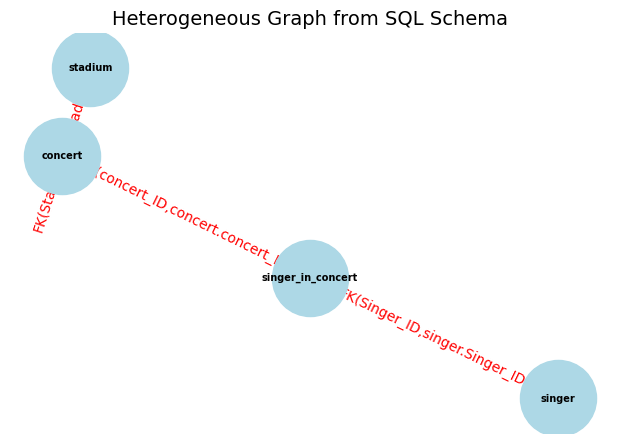

In [92]:
# Function to visualize the graph (table only)
def visualize_graph_table(G):
    plt.figure(figsize=(6, 4))
    
    # Define positions for the nodes
    pos = nx.spring_layout(G, seed=42)  # Spring layout for better visualization

    # Draw the graph
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=3000, font_size=7, font_weight='bold', edge_color='gray')

    # Draw edge labels (foreign key relations)
    edge_labels = nx.get_edge_attributes(G, 'relation')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

    plt.title('Heterogeneous Graph from SQL Schema', fontsize=14)
    plt.show()

# Visualize the graph
visualize_graph_table(G)

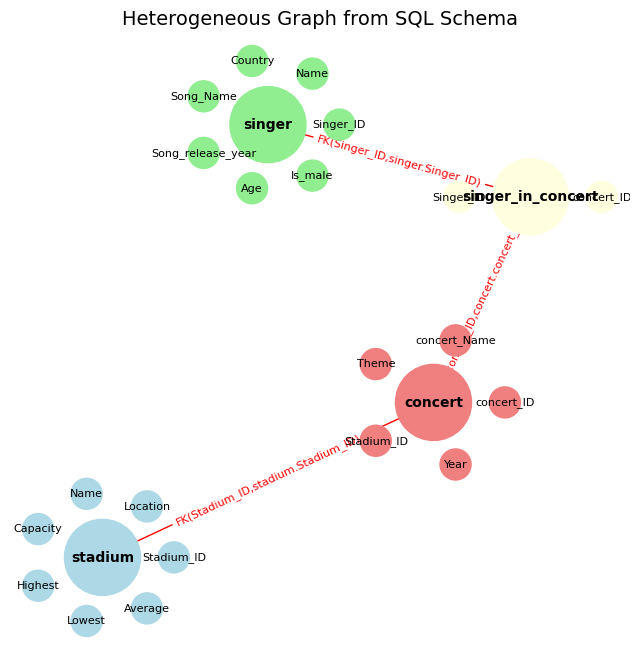

In [93]:
# Function to visualize the graph (table and column)
def visualize_graph(G):
    plt.figure(figsize=(8, 8))

    # Get positions using spring layout
    pos = nx.spring_layout(G, seed=88)

    # Create a mapping for table colors
    table_colors = {
        "stadium": "lightblue",
        "singer": "lightgreen",
        "concert": "lightcoral",
        "singer_in_concert": "lightyellow"
    }

    # Separate nodes
    table_nodes = []
    column_nodes = []
    column_color_map = {}

    for node, data in G.nodes(data=True):
        if 'fields' in data:
            table_nodes.append(node)  # Add table nodes
            for field in data['fields']:
                column_node = f"{node}.{field}"
                column_nodes.append(column_node)  # Prepare column nodes
                column_color_map[column_node] = table_colors[node]  # Assign color based on the table

    # Update positions to adjust distances
    for i, table in enumerate(table_nodes):
        pos[table][0] += i * 0.5  # Increase distance between tables on the x-axis
        pos[table][1] += i * 0.2

        # Calculate positions for columns around the table
        num_columns = len(G.nodes[table]['fields'])
        for j, field in enumerate(G.nodes[table]['fields']):
            angle = 2 * np.pi * j / num_columns  # Calculate angle for circular layout
            radius = 0.3  # Distance from table to column nodes
            column_node = f"{table}.{field}"
            pos[column_node] = pos[table] + np.array([radius * np.cos(angle), radius * np.sin(angle)])

    # Draw table nodes
    nx.draw_networkx_nodes(G, pos, nodelist=table_nodes, node_color=list(table_colors.values()), 
                           node_size=3000, label='Tables')

    # Draw column nodes (fields) with assigned colors
    column_node_colors = [column_color_map[node] for node in column_nodes]
    nx.draw_networkx_nodes(G, pos, nodelist=column_nodes, 
                            node_color=column_node_colors, node_size=500, label='Columns')

    # Draw edges with different colors
    edge_colors = []
    for u, v in G.edges():
        if u in column_nodes and v in table_nodes:  # column to table edge
            edge_colors.append('black')
        elif u in table_nodes and v in table_nodes:  # table to table edge
            edge_colors.append('red')
        else:  # in case of any other relationship, default to gray
            edge_colors.append('gray')

    nx.draw_networkx_edges(G, pos, edge_color=edge_colors)
    # nx.draw_networkx_edges(G, pos, edge_color='gray')
    
    # Draw labels for tables
    nx.draw_networkx_labels(G, pos, labels={node: node for node in table_nodes}, font_size=10, font_weight='bold')

    # Draw labels for fields (columns)
    field_labels = {f"{table}.{field}": field for table in table_nodes for field in G.nodes[table]['fields']}
    nx.draw_networkx_labels(G, pos, labels=field_labels, font_size=8, font_color='black')

    # Draw edge labels (foreign key relations)
    edge_labels = nx.get_edge_attributes(G, 'relation')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=8)

    plt.title('Heterogeneous Graph from SQL Schema', fontsize=14)
    plt.axis('off')  # Hide the axis
    plt.show()

# Visualize the graph
visualize_graph(G)


In [ ]:
# TODO
# 1. create and save graphs for each database
# 2. try spider, bird, and other datasets